# PROJECT EXECUTION — STEP-BY-STEP

## STEP 1 — Install Required Libraries
    pip install pandas numpy matplotlib seaborn statsmodels scikit-learn ipywidgets

# STEP 2 — Create Your Project File
    Create main.ipynb or main.py
    Start with imports + loading dataset.#

## STEP 3 — LOAD DATA

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('colorado_motor_vehicle_sales.csv')

df.head()

,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


## STEP 4 — CHECK & CLEAN DATA

In [8]:
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     501 non-null    int64 
 1   quarter  501 non-null    int64 
 2   county   501 non-null    object
 3   sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


,year,quarter,sales
count,501.000000,501.000000,5.010000e+02
mean,2011.570858,2.502994,1.760585e+08
std,2.266599,1.120041,1.642055e+08
min,2008.000000,1.000000,6.274000e+06
25%,2010.000000,2.000000,6.148200e+07
50%,2012.000000,3.000000,1.385820e+08
75%,2014.000000,4.000000,2.241580e+08
max,2015.000000,4.000000,9.169100e+08


## STEP 5 — CREATE PERIOD COLUMN (YEAR + QUARTER)

In [9]:
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

## STEP 6 — EXPLORATORY DATA ANALYSIS (EDA)

### A. Histograms & Bar Charts

(501, 5)
year        int64
quarter     int64
county     object
sales       int64
period     object
dtype: object
year       0
quarter    0
county     0
sales      0
period     0
dtype: int64
              year     quarter         sales
count   501.000000  501.000000  5.010000e+02
mean   2011.570858    2.502994  1.760585e+08
std       2.266599    1.120041  1.642055e+08
min    2008.000000    1.000000  6.274000e+06
25%    2010.000000    2.000000  6.148200e+07
50%    2012.000000    3.000000  1.385820e+08
75%    2014.000000    4.000000  2.241580e+08
max    2015.000000    4.000000  9.169100e+08


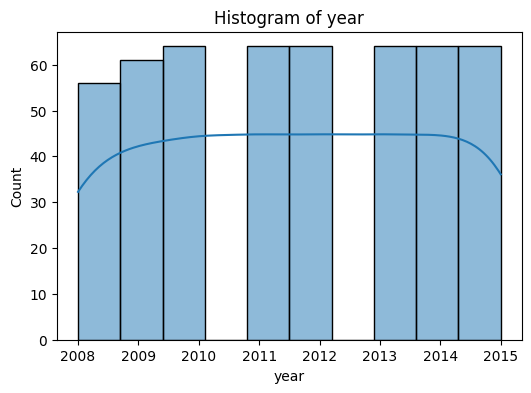

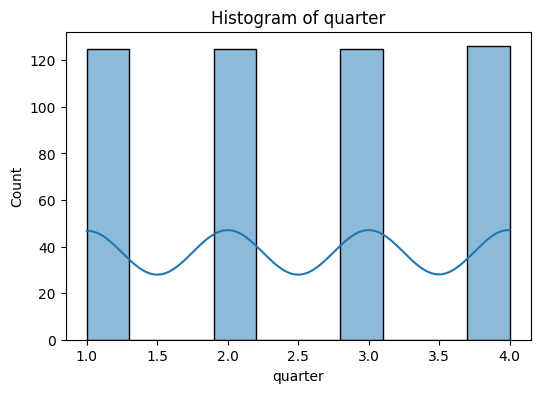

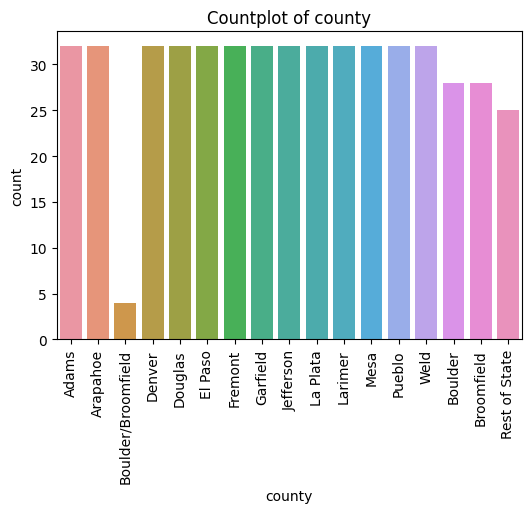

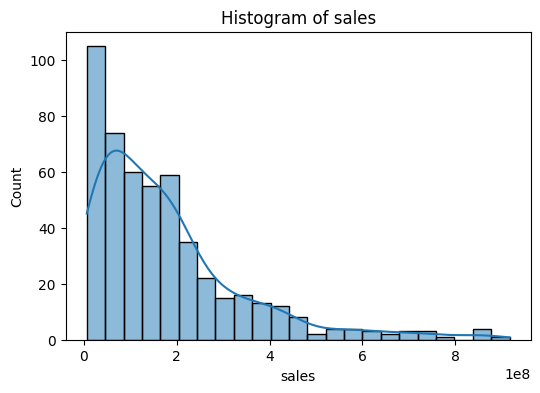

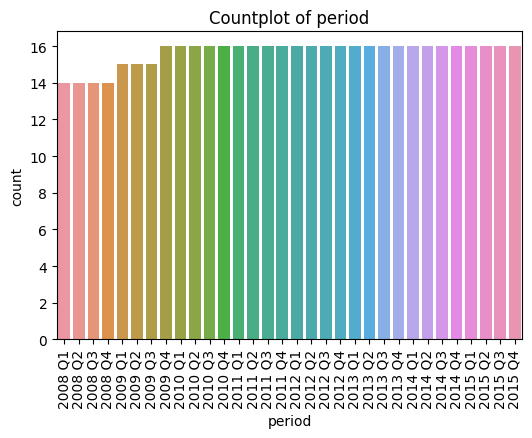

In [10]:
def perform_eda(df):
    print(df.shape)
    print(df.dtypes)
    print(df.isnull().sum())
    print(df.describe())

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(6,4))
            sns.histplot(df[col], kde=True)
            plt.title(f"Histogram of {col}")
            plt.show()
        else:
            plt.figure(figsize=(6,4))
            sns.countplot(x=df[col])
            plt.title(f"Countplot of {col}")
            plt.xticks(rotation=90)
            plt.show()

perform_eda(df)

### B. SALES OVER TIME

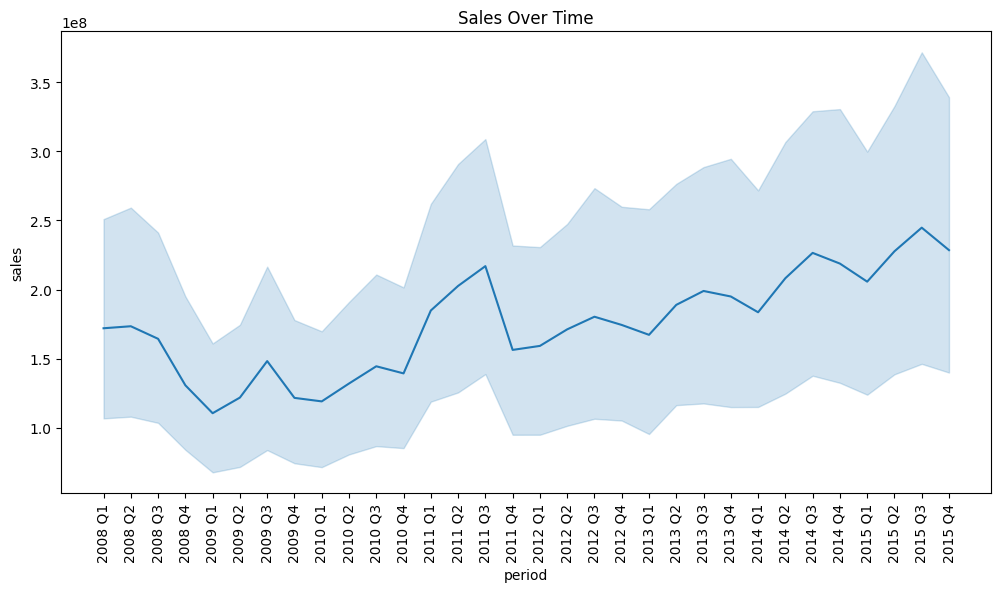

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='period', y='sales')
plt.title("Sales Over Time")
plt.xticks(rotation=90)
plt.show()

### C. SALES DISTRIBUTION BY QUARTER

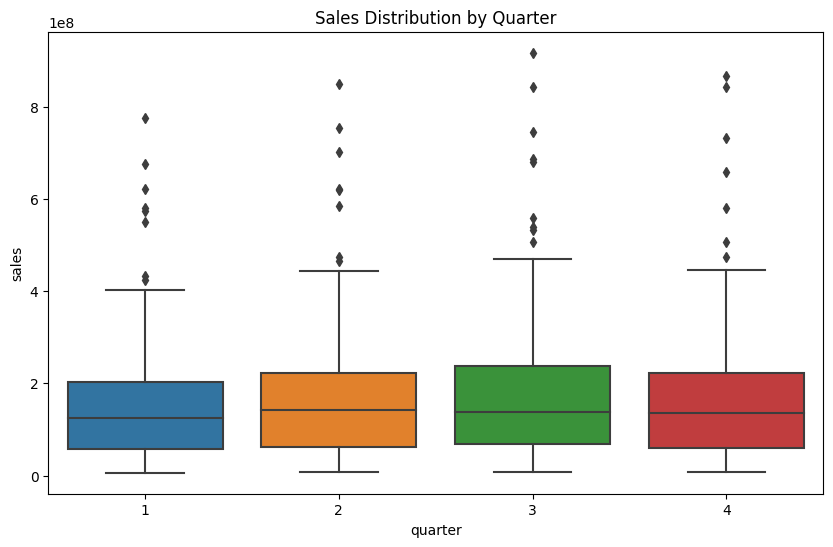

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='quarter', y='sales')
plt.title("Sales Distribution by Quarter")
plt.show()

### D. INTERACTIVE SLIDER — SALES BY COUNTY

    Requires ipywidgets.

In [13]:
import ipywidgets as widgets

def plot_sales_by_county(year, quarter):
    temp = df[(df['year']==year) & (df['quarter']==quarter)]
    g = temp.groupby('county')['sales'].sum().reset_index()
    g = g.sort_values('sales', ascending=False)

    plt.figure(figsize=(14,6))
    sns.barplot(data=g, x='county', y='sales')
    plt.xticks(rotation=90)
    plt.title(f"Sales by County ({year} Q{quarter})")
    plt.show()

widgets.interact(
    plot_sales_by_county,
    year = widgets.IntSlider(min=df.year.min(), max=df.year.max(), step=1),
    quarter = widgets.IntSlider(min=1, max=4, step=1)
)

interactive(children=(IntSlider(value=2008, description='year', max=2015, min=2008), IntSlider(value=1, descri…

<function __main__.plot_sales_by_county(year, quarter)>

## STEP 7 — PREDICTIVE MODEL (Random Forest)

### Convert county to numeric

In [14]:
df['county'] = df['county'].astype('category').cat.codes

### Train-Test Split

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = df[['year','quarter','county']]
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Train Model

In [16]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

### Predictions & RMSE

In [17]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

19981856.206187755

## STEP 8 — ARIMA TIME SERIES FORECASTING

    You must convert yearly/quarterly to a proper time index.

### Build a Time Series Monthly Index

    We convert quarter into a month:

In [22]:
df['month'] = df['quarter'].map({1:1, 2:4, 3:7, 4:10})
df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))
ts = df.groupby('date')['sales'].sum()
ts.index = pd.to_datetime(ts.index)   
ts.index = pd.PeriodIndex(ts.index, freq='Q').to_timestamp()                 

### Plot Time Series

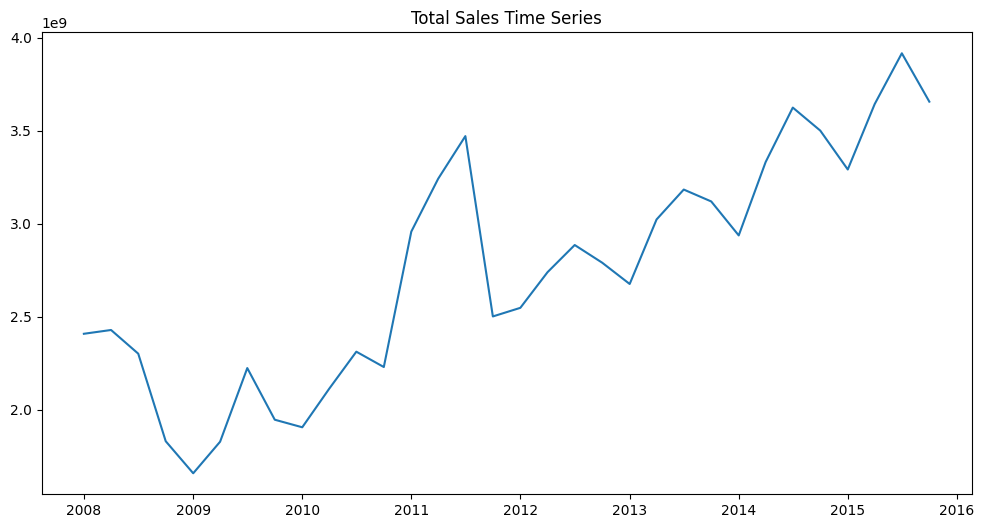

In [24]:
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.title("Total Sales Time Series")
plt.show()

### Seasonal Decomposition

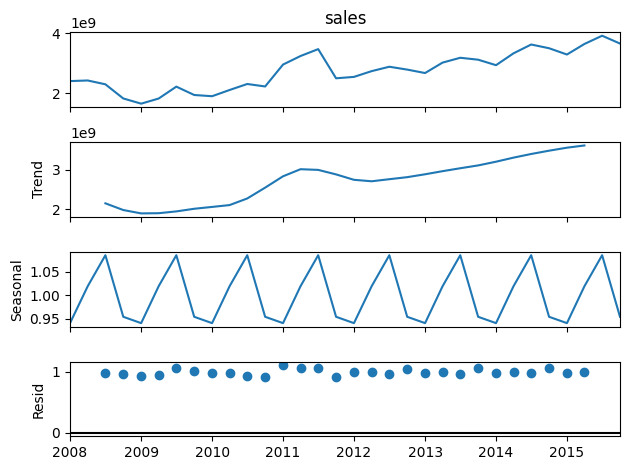

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, model='multiplicative', period=4)
decomposition.plot()
plt.show()

### Fit ARIMA Model

In [26]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts, order=(1,1,1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   32
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -649.942
Date:                Tue, 09 Dec 2025   AIC                           1305.885
Time:                        21:03:57   BIC                           1310.187
Sample:                    01-01-2008   HQIC                          1307.287
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6056      0.732      0.827      0.408      -0.829       2.041
ma.L1         -0.7056      0.623     -1.133      0.257      -1.926       0.515
sigma2       9.87e+16        nan        nan        n

### Forecast Next 12 Months

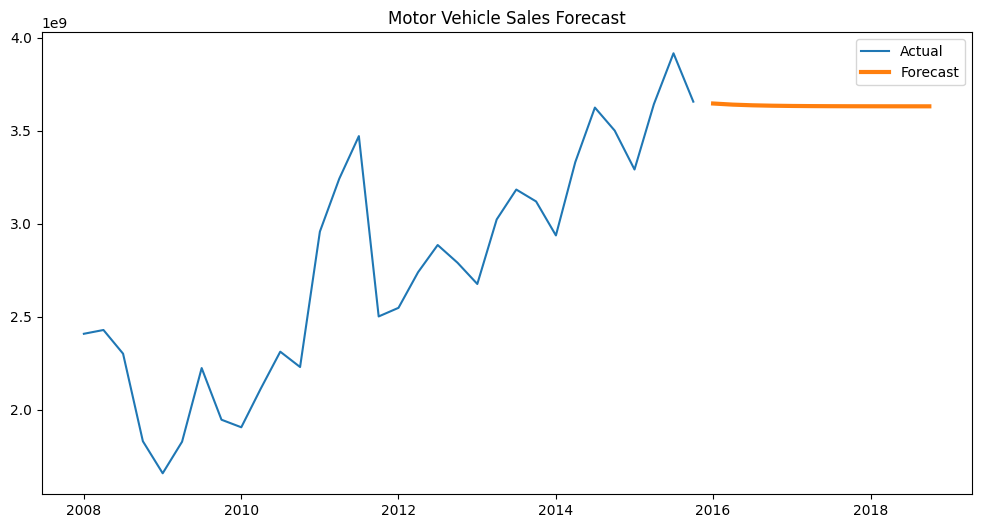

In [27]:
forecast = fit.forecast(steps=12)

plt.figure(figsize=(12,6))
plt.plot(ts, label="Actual")
plt.plot(forecast, label="Forecast", linewidth=3)
plt.legend()
plt.title("Motor Vehicle Sales Forecast")
plt.show()

## STEP 9 — FINAL REPORT GENERATION

In [28]:
report = f"""
Colorado Motor Vehicle Sales — Final Analysis Report
----------------------------------------------------

DATA RANGE : {ts.index.min()} to {ts.index.max()}
TOTAL RECORDS: {len(df)}

KEY FINDINGS:
1. Clear seasonal trend in quarterly sales.
2. County-wise sales distribution shows high concentration in major counties.
3. Random Forest RMSE = {rmse:.2f}
4. ARIMA forecasting shows steady upward trend for next 12 months.

CONCLUSION:
The dataset shows strong seasonality and steady growth patterns. 
The forecasting model helps predict future vehicle demand and supports 
economic planning for dealerships and policymakers.
"""

print(report)



Colorado Motor Vehicle Sales — Final Analysis Report
----------------------------------------------------

DATA RANGE : 2008-01-01 00:00:00 to 2015-10-01 00:00:00
TOTAL RECORDS: 501

KEY FINDINGS:
1. Clear seasonal trend in quarterly sales.
2. County-wise sales distribution shows high concentration in major counties.
3. Random Forest RMSE = 19981856.21
4. ARIMA forecasting shows steady upward trend for next 12 months.

CONCLUSION:
The dataset shows strong seasonality and steady growth patterns. 
The forecasting model helps predict future vehicle demand and supports 
economic planning for dealerships and policymakers.

